#### 4. Running KMeans on full dataset

In [1]:
# ssh -NL 12345:localhost:27017 awscloud
from pymongo import MongoClient
client = MongoClient(port=12345) # this is the port set by the SSH tunnel
db = client.pubmed_ad # database name

In [2]:
db.alz.count()

130672

In [3]:
# create lists containing BOTH abstracts (AB) or titles (TI)
cursor = db.alz.find(
    { 'AB': { '$ne': None }, 'TI': {'$ne': None}},
    { 'AB': 1, '_id': 0, 'TI': 1 }
)

docs = list(cursor)

In [4]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from collections import Counter

In [5]:
# gather the abstracts
docs_ab = []

for i, abstract in enumerate(d['AB'] for d in docs): 
    docs_ab.append(abstract)

In [12]:
len(docs_ab) #115509
len(docs_ab)/(db.alz.count())

0.8839613689237173

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# Preprocessing pipeline

pipe = [
    ('tfidf', TfidfVectorizer(stop_words="english", 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=3)),
    ('lsa', TruncatedSVD(n_components=300)),
    ('norm', Normalizer())
]
pipe = Pipeline(pipe)

#### Abstracts

In [8]:
dtm_svd = pipe.fit_transform(docs_ab)
dtm_svd_df = pd.DataFrame(dtm_svd)

In [9]:
# Fit the model on preprocessed abstract data

km = KMeans(n_clusters=10)
km.fit(dtm_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
# centroids for abstracts
mu_digits_ab = km.cluster_centers_

In [11]:
# Count up the number of abstracts in each cluster
clusters = km.fit_predict(dtm_svd)
Counter(clusters)

Counter({0: 12792,
         1: 4456,
         2: 19485,
         3: 15530,
         4: 6912,
         5: 8712,
         6: 12801,
         7: 4708,
         8: 6587,
         9: 23526})

In [13]:
# Topic modeling, which come from tfidf matrix containing 41634 features (words) and reduced to 300 in trunc_svd.

def print_topic_top_words(pipe, n_topics=10, n_words=10):
    cv = pipe.steps[0][1] # tfidf_vec, 115K x 41K
    model = pipe.steps[1][1] # trunc_svd 41K x 300
    feature_names = cv.get_feature_names() # word features from tfidf
    
    for topic_num in range(n_topics):
        topic_mat = model.components_[topic_num] # words found in trunc_svd
        
        print('Topic {}:'.format(topic_num + 1).center(80)) 
        
        topic_values = sorted(zip(topic_mat, feature_names), 
                              reverse=True)[:n_words]
        print(' '.join([y for x,y in topic_values])) # returns a list/grouping of the most important words 
        print('-'*80)
        
        
print_topic_top_words(pipe)

                                    Topic 1:                                    
ad abeta patients disease amyloid dementia tau beta brain alzheimer
--------------------------------------------------------------------------------
                                    Topic 2:                                    
abeta beta app amyloid protein tau mice cells peptide cell
--------------------------------------------------------------------------------
                                    Topic 3:                                    
tau phosphorylation csf microtubule protein phosphorylated neurofibrillary tangles phf tauopathies
--------------------------------------------------------------------------------
                                    Topic 4:                                    
abeta ad tau csf mci apoe patients subjects controls allele
--------------------------------------------------------------------------------
                                    Topic 5:                      

In [14]:
len(pipe.steps[0][1].get_feature_names())
# feature_names is coming from tfidf vectorizer
# from the 41634 words in the abstracts, chose to reduce to 300 in TruncSVD. 

41634

In [16]:
import pdb
# Goal here is to give each cluster a name/names based km.cluster_centers_ (set to mu_digits from earlier code)
# and mapping to feature names from TruncSVD (pipe.steps[1][1] from pipeline).

from sklearn.feature_extraction.text import TfidfTransformer

print('Top Terms Per Cluster')
original_space_centroids = pipe.steps[1][1].inverse_transform(mu_digits_ab)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = pipe.steps[0][1].get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top Terms Per Cluster
Cluster 0: diseases disease neurodegenerative disorders ad brain review alzheimer proteins protein
Cluster 1: app secretase gamma beta amyloid abeta protein precursor ad processing
Cluster 2: abeta ad amyloid beta peptide mice brain induced aggregation disease
Cluster 3: ad patients mci subjects cognitive controls memory disease group mild
Cluster 4: apoe ad risk allele gene genetic association onset polymorphism disease
Cluster 5: tau phosphorylation protein ad microtubule phosphorylated csf neurofibrillary disease tangles
Cluster 6: ad mice brain cells neurons activity disease expression induced alzheimer
Cluster 7: beta amyloid protein peptide fibrils plaques formation disease aggregation ad
Cluster 8: dementia patients cognitive disease clinical ad alzheimer risk treatment study
Cluster 9: care caregivers dementia health caregiver family patients home patient people


#### Titles. What are the catchiest words used in journal article titles?

In [21]:
# all the titles
docs_ti = []

for i, title in enumerate(d['TI'] for d in docs): 
    docs_ti.append(title)
    
len(docs_ti)

115509

In [22]:
dtm2_svd = pipe.fit_transform(docs_ti)
dtm2_svd_df = pd.DataFrame(dtm2_svd)

In [23]:
km2 = KMeans(n_clusters=10)
km2.fit(dtm2_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
clusters_ti = km2.fit_predict(dtm2_svd)
Counter(clusters_ti)

Counter({0: 12738,
         1: 6968,
         2: 29006,
         3: 10368,
         4: 34581,
         5: 3880,
         6: 5403,
         7: 4078,
         8: 4939,
         9: 3548})

In [26]:
mu_digits_ti = km2.cluster_centers_

In [27]:
print('Top Terms Per Cluster')
original_space_centroids = pipe.steps[1][1].inverse_transform(mu_digits_ti)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = pipe.steps[0][1].get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top Terms Per Cluster
Cluster 0: amyloid beta protein precursor peptide alzheimer disease induced cells peptides
Cluster 1: brain alzheimer disease human aging barrier blood expression mouse rat
Cluster 2: disease alzheimer patients treatment risk model early analysis onset clinical
Cluster 3: dementia alzheimer type patients vascular disease lewy frontotemporal bodies care
Cluster 4: human abeta induced cells effects mice receptor protein cognitive activity
Cluster 5: memory alzheimer disease learning impairment mice deficits spatial induced episodic
Cluster 6: study alzheimer disease dementia patients risk pilot longitudinal based prospective
Cluster 7: tau phosphorylation protein alzheimer disease pathology hyperphosphorylation microtubule phosphorylated amyloid
Cluster 8: cognitive impairment mild disease alzheimer patients amnestic dementia study memory
Cluster 9: diseases neurodegenerative disorders role disease therapeutic protein neurological parkinson alzheimer


In [28]:
print_topic_top_words(pipe)

                                    Topic 1:                                    
disease alzheimer amyloid dementia beta cognitive patients protein impairment brain
--------------------------------------------------------------------------------
                                    Topic 2:                                    
amyloid beta protein precursor peptide induced cells human tau mice
--------------------------------------------------------------------------------
                                    Topic 3:                                    
cognitive impairment mild dementia amyloid beta decline memory amnestic vascular
--------------------------------------------------------------------------------
                                    Topic 4:                                    
dementia type vascular lewy bodies frontotemporal study patients diagnosis senile
--------------------------------------------------------------------------------
                                    T

#### Recommender?

In [17]:
# pipe.steps[1][1] refers to TruncatedSVD from pipeline
svd = pipe.steps[1][1]

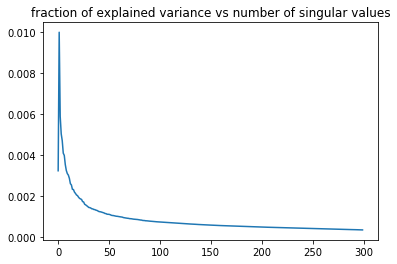

In [18]:
plt.plot(svd.explained_variance_ratio_)
plt.title('fraction of explained variance vs number of singular values')

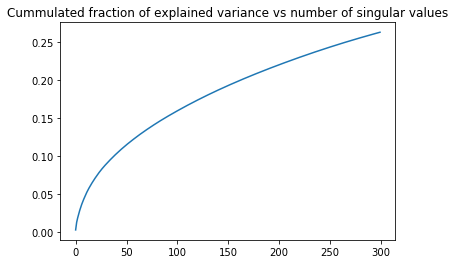

In [19]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title('Cummulated fraction of explained variance vs number of singular values');

In [20]:
# transformed similarity
# this does not yet work. 
from sklearn.metrics.pairwise import cosine_similarity

components = pd.DataFrame(svd.components_, columns=ratings_pivot.columns) # need equiv of ratings_pivot here
def item_similarity_new(abstract1, abstract2):
    return cosine_similarity(components.loc[:,abstract1].values.reshape(1,-1),components.loc[:,abstract2].values.reshape(1,-1))

def get_similar_abstracts(abstract, n=3, sim=item_similarity):
    item_sims = []
    for m in ratings_pivot.columns:
        if movieId != m:
            item_sims.append((m, sim(movieId,m)[0,0]))
    res = sorted(item_sims, key=lambda x: -x[1])[:n]
    return list(map(lambda x: (movies.title[x[0]], np.round(x[1],3)), res))

NameError: name 'ratings_pivot' is not defined